# Group 14 - Project FP01
## Time series anomaly detection - LSTM-AD

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
# transform in like collision
collisions['Timestamp'] = collisions_adjusted

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 118.01169610023499 seconds ---


In [6]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


In [7]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)

In [8]:
y_test_collision = df_with_labels["is_collision"]


## LSTM-AD

In [9]:
from algorithms.lstm_ad import LSTMAD

def prepare_data_for_lstm(data, len_in):
    """
    Prepare data for LSTM-AD by concatenating every len_in rows.
    """
    n_features = data.shape[1]
    n_samples = data.shape[0] // len_in
    prepared_data = data.iloc[:n_samples * len_in].values.reshape(n_samples, -1)
    return pd.DataFrame(prepared_data, index=data.index[len_in-1:len_in*n_samples:len_in])

# CURRENTLY FUCKS UP FOR VALUES OF LEN_IN AND LEN_OUT DIFFERENT FROM 1
len_in = 1
X_train_lstm = prepare_data_for_lstm(X_train, len_in)
print(X_train_lstm.shape)

classifier = LSTMAD(
    len_in=len_in,         # Input sequence length
    len_out=1,             # Output sequence length (prediction horizon)
    num_epochs=100,         # Number of training epochs
    lr=1e-3,               # Learning rate
    batch_size=1,          # Batch size (usually 1 for time series)
    seed=42,               # Random seed for reproducibility
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True           # Set to True to get detailed predictions
)

# Train the LSTM on normal data
classifier.fit(X_train_lstm)
print("LSTM-AD training completed.")


(973, 96)


100%|██████████| 100/100 [00:33<00:00,  2.98it/s]

LSTM-AD training completed.


### Anomaly Detection

In [10]:
anomaly_scores = None
try:
    anomaly_scores = classifier.predict(X_test)
    # Replace inf values with the maximum float value
    anomaly_scores = np.nan_to_num(anomaly_scores, nan=np.nanmean(anomaly_scores), posinf=np.finfo(float).max, neginf=np.finfo(float).min)
except Exception as e:
    print(f"An error occurred during prediction: {str(e)}")
    # If an error occurs, you might want to inspect the model's internal state
print("Anomaly prediction completed.")

Anomaly prediction completed.


In [11]:
threshold_1 = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

In [12]:
median = np.median(anomaly_scores)
mad = np.median(np.abs(anomaly_scores - median))
threshold_2 = median + 3 * mad  

In [13]:
threshold_3 = np.percentile(anomaly_scores, 95)

In [14]:
Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)
IQR = Q3 - Q1
threshold_4 = Q3 + 1.5 * IQR

In [15]:
for threshold in [threshold_1, threshold_2, threshold_3, threshold_4]:
    anomalies_detected = sum(anomaly_scores >= threshold)
    print(f"Number of anomalies detected: {anomalies_detected} with threshold {threshold}")

Number of anomalies detected: 2 with threshold 850319.5580718152
Number of anomalies detected: 94 with threshold 19654.227463451036
Number of anomalies detected: 16 with threshold 205900.48671233509
Number of anomalies detected: 21 with threshold 59843.65811369098


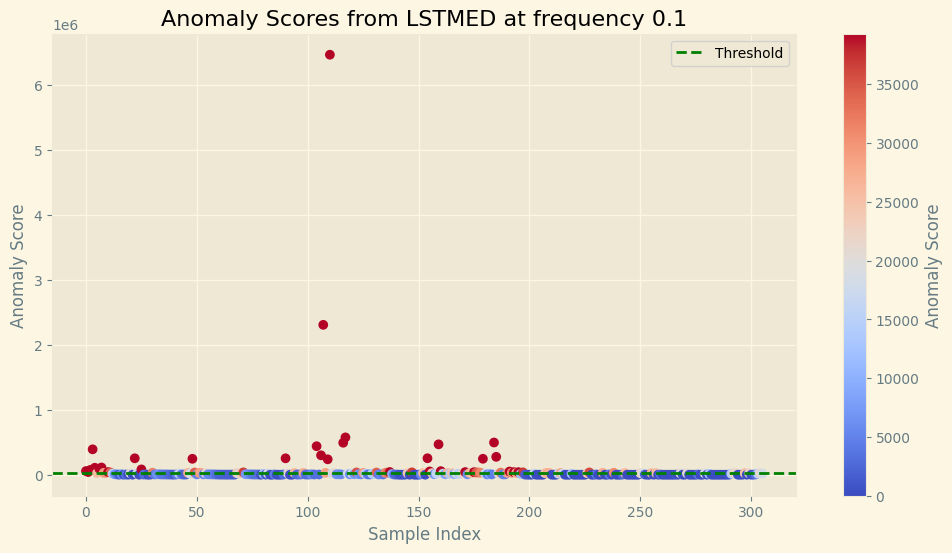

Number of anomalies detected: 94


In [16]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, threshold_2)

In [17]:
np.count_nonzero(y_test_collision)

105

In [18]:
compute_metrics(anomaly_scores, y_test_collision, threshold_2)

ROC AUC Score: 0.8321
Detected anomaly class: 1
Threshold: 19654.2275
F1 Score: 0.6533
Accuracy: 0.7745
Precision: 0.6915
Recall: 0.6190
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       201
           1       0.69      0.62      0.65       105

    accuracy                           0.77       306
   macro avg       0.75      0.74      0.74       306
weighted avg       0.77      0.77      0.77       306



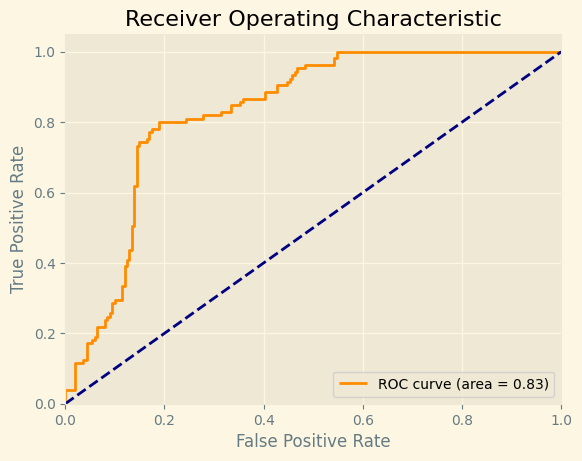

In [19]:
plot_roc_curve(y_test_collision.values, anomaly_scores)

## Map anomalies to original time series

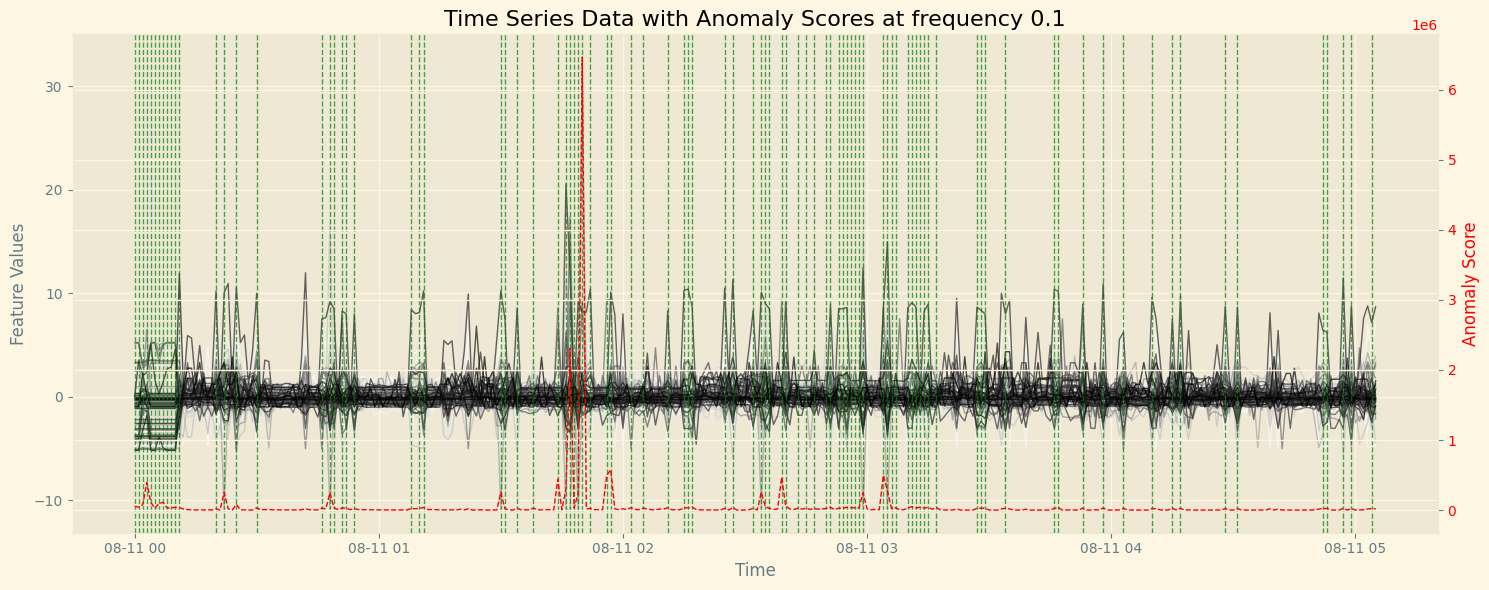

Top 94 Anomalies:
              timestamp  anomaly_score  \
110 2022-08-11 01:50:00   6.467558e+06   
107 2022-08-11 01:47:00   2.308014e+06   
117 2022-08-11 01:57:00   5.747370e+05   
184 2022-08-11 03:04:00   4.961377e+05   
116 2022-08-11 01:56:00   4.924773e+05   
..                  ...            ...   
271 2022-08-11 04:31:00   2.073180e+04   
20  2022-08-11 00:20:00   2.053522e+04   
268 2022-08-11 04:28:00   2.024289e+04   
167 2022-08-11 02:47:00   2.019435e+04   
186 2022-08-11 03:06:00   2.005330e+04   

     machine_nameKuka Robot_apparent_power-_Average power  \
110                                          -0.911260      
107                                          -1.181816      
117                                          -1.299415      
184                                          -1.514041      
116                                           0.033111      
..                                                 ...      
271                                          -0.81

In [20]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)